In [1]:
import pandas as pd
import scipy.stats as st
from datetime import datetime
from datetime import timedelta
import math
import numpy as np
from PIL import Image
from scipy import stats
from keras.utils.np_utils import to_categorical
import tensorflow as tf
import keras.backend.tensorflow_backend as K
from sklearn.model_selection import train_test_split


import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
patient_route = pd.read_csv('covid19/PatientRoute.csv')
patient_info = pd.read_csv('covid19/PatientInfo.csv')

dates = patient_route['date']
first = datetime.strptime(dates[0], '%Y-%m-%d')
last = datetime.strptime(dates.max(), '%Y-%m-%d')

In [3]:
patient_route

,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.0,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.615246,126.715632
1,1000000001,2.0,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659
2,1000000002,5.0,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048
3,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822
4,1000000002,5.0,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534
...,...,...,...,...,...,...,...,...
6709,6100000090,NaN,2020-03-24,Seoul,Gangseo-gu,airport,37.558654,126.794474
6710,6100000090,NaN,2020-03-24,Busan,Gangseo-gu,airport,35.173220,128.946459
6711,6100000090,NaN,2020-03-25,Gyeongsangnam-do,Yangsan-si,store,35.336944,129.026389
6712,6100000090,NaN,2020-03-25,Gyeongsangnam-do,Yangsan-si,hospital,35.335757,129.025003


In [4]:
patient_info

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3383,7000000009,9651.0,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,NaN,NaN,14.0,NaN,2020-03-29,NaN,NaN,isolated
3384,7000000010,NaN,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,NaN,NaN,18.0,NaN,2020-04-03,NaN,NaN,isolated
3385,7000000011,NaN,male,NaN,30s,Korea,Jeju-do,Jeju-do,NaN,contact with patient,NaN,7.000000e+09,5.0,NaN,2020-04-03,NaN,NaN,isolated
3386,7000000012,NaN,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,NaN,NaN,9.0,NaN,2020-04-03,NaN,NaN,isolated


In [5]:
infected_by = patient_info['infected_by'].dropna()
infected_by = infected_by.drop_duplicates(keep='first', inplace=False)#.tolist()
print(infected_by)


2       2.002000e+09
4       1.000000e+09
5       1.000000e+09
12      1.000000e+09
13      1.000000e+09
            ...     
3337    6.100000e+09
3347    6.002000e+09
3369    6.100000e+09
3370    6.100000e+09
3385    7.000000e+09
Name: infected_by, Length: 370, dtype: float64


In [6]:
patient_info = patient_info[["patient_id","global_num","sex","age","infection_case"]]

In [7]:
merge_route = pd.merge(patient_info, patient_route)
merge_route

,patient_id,global_num,sex,age,infection_case,date,province,city,type,latitude,longitude
0,1000000001,2.0,male,50s,overseas inflow,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.615246,126.715632
1,1000000001,2.0,male,50s,overseas inflow,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659
2,1000000002,5.0,male,30s,overseas inflow,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048
3,1000000002,5.0,male,30s,overseas inflow,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822
4,1000000002,5.0,male,30s,overseas inflow,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534
...,...,...,...,...,...,...,...,...,...,...,...
6709,6100000090,NaN,male,40s,overseas inflow,2020-03-24,Seoul,Gangseo-gu,airport,37.558654,126.794474
6710,6100000090,NaN,male,40s,overseas inflow,2020-03-24,Busan,Gangseo-gu,airport,35.173220,128.946459
6711,6100000090,NaN,male,40s,overseas inflow,2020-03-25,Gyeongsangnam-do,Yangsan-si,store,35.336944,129.026389
6712,6100000090,NaN,male,40s,overseas inflow,2020-03-25,Gyeongsangnam-do,Yangsan-si,hospital,35.335757,129.025003


In [8]:
merge_route = merge_route[merge_route["province"]=="Seoul"]
merge_route

,patient_id,global_num,sex,age,infection_case,date,province,city,type,latitude,longitude
1,1000000001,2.0,male,50s,overseas inflow,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659
2,1000000002,5.0,male,30s,overseas inflow,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048
3,1000000002,5.0,male,30s,overseas inflow,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822
4,1000000002,5.0,male,30s,overseas inflow,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534
5,1000000002,5.0,male,30s,overseas inflow,2020-01-26,Seoul,Seongbuk-gu,public_transportation,37.590330,127.015221
...,...,...,...,...,...,...,...,...,...,...,...
5875,6011000010,NaN,female,20s,contact with patient,2020-02-19,Seoul,Mapo-gu,store,37.551936,126.921668
6298,6023000011,839.0,female,10s,NaN,2020-02-21,Seoul,Dongjak-gu,hospital,37.498990,126.937719
6492,6100000024,NaN,male,30s,contact with patient,2020-02-24,Seoul,Gangdong-gu,pharmacy,37.533819,127.137649
6708,6100000090,NaN,male,40s,overseas inflow,2020-03-24,Seoul,Gangseo-gu,airport,37.558654,126.794474


In [9]:
merge_route = merge_route[pd.notnull(merge_route['sex'])]
merge_route = merge_route[pd.notnull(merge_route['age'])]

In [10]:
class GridMap:
    Re = 6371.00877  ##  지도반경
    grid = 0.16  ##  격자간격 (km)
    slat1 = 30.0  ##  표준위도 1
    slat2 = 60.0  ##  표준위도 2
    olon = 127.0175205  ##  기준점 경도
    olat = 37.523124  ##  기준점 위도
    xo = 18.4 / grid #  기준점 X좌표
    yo = 21.6 / grid  ##  기준점 Y좌표
    row = 256
    column = 256
    seoul_start_lat = 37.698098
    seoul_start_lon = 126.799791
    seoul_end_lat = 37.34815
    seoul_end_lon = 127.23525

    def __init__(self):
        self.PI = math.asin(1.0) * 2.0
        self.DEGRAD = self.PI / 180.0
        self.RADDEG = 180.0 / self.PI

        self.re = self.Re / self.grid
        self.slat1 = self.slat1 * self.DEGRAD
        self.slat2 = self.slat2 * self.DEGRAD
        self.olon = self.olon * self.DEGRAD
        self.olat = self.olat * self.DEGRAD

        self.sn = math.tan(self.PI * 0.25 + self.slat2 * 0.5) / \
                  math.tan(self.PI * 0.25 + self.slat1 * 0.5)
        self.sn = math.log(math.cos(self.slat1) /
                           math.cos(self.slat2)) / math.log(self.sn)
        self.sf = math.tan(self.PI * 0.25 + self.slat1 * 0.5)
        self.sf = math.pow(self.sf, self.sn) * math.cos(self.slat1) / self.sn
        self.ro = math.tan(self.PI * 0.25 + self.olat * 0.5)
        self.ro = self.re * self.sf / math.pow(self.ro, self.sn)

    def toGrid(self, lat, lon):
        ra = math.tan(self.PI * 0.25 + lat * self.DEGRAD * 0.5)
        ra = self.re * self.sf / pow(ra, self.sn)
        theta = lon * self.DEGRAD - self.olon
        if theta > self.PI:
            theta -= 2.0 * self.PI
        if theta < self.PI * -1:
            theta += 2.0 * self.PI
        theta *= self.sn
        x = (ra * math.sin(theta)) + self.xo
        y = (self.ro - ra * math.cos(theta)) + self.yo
        x = int(x + 1.5)
        # y = int(y + 1.5)
        y = (int(y + 1.5) - 255) * -1
        return x, y

    def toCoordinate(self, x, y):
        x = x - 1
        y = y - 1
        xn = x - self.xo
        yn = self.ro - y + self.yo
        ra = math.sqrt(xn * xn + yn * yn)
        if self.sn < 0.0:
            ra = -ra
        alat = math.pow((self.re * self.sf / ra), (1.0 / self.sn))
        alat = 2.0 * math.atan(alat) - self.PI * 0.5
        if math.fabs(xn) <= 0.0:
            theta = 0.0
        else:
            if math.fabs(yn) <= 0.0:
                theta = self.PI * 0.5
                if xn < 0.0:
                    theta = -theta
            else:
                theta = math.atan2(xn, yn)
        alon = theta / self.sn + self.olon
        lat = alat * self.RADDEG
        lon = alon * self.RADDEG
        return lat, lon

    def isSeoul(self, lat, lon):
        if self.seoul_end_lat > lat or lat > self.seoul_start_lat:
            return False
        if self.seoul_end_lon < lon or lon < self.seoul_start_lon:
            return False
        return True

    def generateMap(self, raw_data):
        gridx, gridy = [], []
        for idx, data in raw_data.iterrows():
            try:
                float(data.latitude)
            except ValueError:
                continue
            if self.isSeoul(data.latitude, data.longitude):
                x, y = self.toGrid(data.latitude, data.longitude)
                gridx.append(x), gridy.append(y)

        df = pd.DataFrame({'gridx': gridx, 'gridy': gridy})

        grid_array = np.zeros((self.row, self.column))
        for idx, data in df.iterrows():
            try:
                grid_array[data.gridy, data.gridx] += 1
            except:
                pass

        return grid_array

In [11]:
converter = GridMap()

In [12]:
merge_route.assign(Name='contact')
merge_route

,patient_id,global_num,sex,age,infection_case,date,province,city,type,latitude,longitude
1,1000000001,2.0,male,50s,overseas inflow,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659
2,1000000002,5.0,male,30s,overseas inflow,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048
3,1000000002,5.0,male,30s,overseas inflow,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822
4,1000000002,5.0,male,30s,overseas inflow,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534
5,1000000002,5.0,male,30s,overseas inflow,2020-01-26,Seoul,Seongbuk-gu,public_transportation,37.590330,127.015221
...,...,...,...,...,...,...,...,...,...,...,...
5875,6011000010,NaN,female,20s,contact with patient,2020-02-19,Seoul,Mapo-gu,store,37.551936,126.921668
6298,6023000011,839.0,female,10s,NaN,2020-02-21,Seoul,Dongjak-gu,hospital,37.498990,126.937719
6492,6100000024,NaN,male,30s,contact with patient,2020-02-24,Seoul,Gangdong-gu,pharmacy,37.533819,127.137649
6708,6100000090,NaN,male,40s,overseas inflow,2020-03-24,Seoul,Gangseo-gu,airport,37.558654,126.794474


In [13]:
public_area = ['bar', 'church', 'karaoke', 'public_transportation', 'gym', 'pc_cafe', 'school', 'etc']

cnt_1 = 0
cnt_2 = 0
for index, row in merge_route.iterrows():
    if row['type'] in public_area:
        merge_route.at[index,'contact'] = 1
        cnt_1 += 1
    else:
        merge_route.at[index,'contact'] = 0
        cnt_2 += 1

print(cnt_1, cnt_2)

1020 1607


In [14]:
merge_route

,patient_id,global_num,sex,age,infection_case,date,province,city,type,latitude,longitude,contact
1,1000000001,2.0,male,50s,overseas inflow,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659,0.0
2,1000000002,5.0,male,30s,overseas inflow,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048,1.0
3,1000000002,5.0,male,30s,overseas inflow,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822,0.0
4,1000000002,5.0,male,30s,overseas inflow,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534,1.0
5,1000000002,5.0,male,30s,overseas inflow,2020-01-26,Seoul,Seongbuk-gu,public_transportation,37.590330,127.015221,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5875,6011000010,NaN,female,20s,contact with patient,2020-02-19,Seoul,Mapo-gu,store,37.551936,126.921668,0.0
6298,6023000011,839.0,female,10s,NaN,2020-02-21,Seoul,Dongjak-gu,hospital,37.498990,126.937719,0.0
6492,6100000024,NaN,male,30s,contact with patient,2020-02-24,Seoul,Gangdong-gu,pharmacy,37.533819,127.137649,0.0
6708,6100000090,NaN,male,40s,overseas inflow,2020-03-24,Seoul,Gangseo-gu,airport,37.558654,126.794474,0.0


In [15]:
# 환자별로 일단 나눠야 함
patients = merge_route['patient_id']
patients = patients.drop_duplicates(keep='last')
patients = patients.tolist()
type(patients)

list

In [16]:
def day_weight(day):
    if day == 0: return 252
    
    return 36 * day

In [17]:
def age_weight(age):
    age = int(age[:-1])
    
    if age == 0: return 23 * 3
    elif age == 80: return 23 * 2
    elif age == 90: return 23 * 1
    elif age == 100: return 23 * 0
    elif age == 10: return 23 * 7
    elif age == 20: return 23 * 10
    elif age == 30: return 23 * 9
    elif age == 40: return 23 * 8
    elif age == 50: return 23 * 6
    elif age == 60: return 23 * 5
    elif age == 70: return 23 * 4
    
    return 0

In [18]:
def sex_weight(sex):
    if sex == "male": return 255
    return 0

In [19]:
def infection_case_weight(infection):
    six = ['bar', 'church', 'karaoke', 'public_transportation']
    five = ['bakery', 'banc', 'etc', 'lodging', 'pharmacy', 'post-office', 'real_estate_agency', 'store']
    four = ['gym', 'pc_cafe', 'school']
    three = ['airport', 'restaurant']
    two = []
    one = ['gas_station']
    
    if infection in six: return 85 * 6
    elif infection in five: return 85 * 5
    elif infection in four: return 85 * 4
    elif infection in three: return 85 * 3
    elif infection in two: return 85 * 2
    return 85

In [20]:
def infection_type_weight(infection_type):
    if infection_type is 'overseas inflow': return 64
    elif infection_type is 'etc': return 64 * 2
    elif infection_type is 'contact with patient': return 64 * 3
    return 64* 4

In [21]:
def contact_weight(contact):
    if contact == 1: return 255
    return 0

In [22]:
class Route:
    def __init__(self, weekday, age, sex, contact, infection_case, visit_type, row, column, lat, lon):
        self.weekday = weekday
        self.age = age
        self.sex = sex
        self.contact = contact
        self.infection_case = infection_case
        self.visit_type = visit_type
        self.row = row
        self.column = column
        self.test = contact
        self.lat = lat
        self.lon = lon
        
    def day_weight(self):
        if self.weekday == 0: return 252
        return 36 * self.weekday
    
    def age_weight(self):
        age = int(self.age[:-1])

        if age == 0: return 23 * 3
        elif age == 80: return 23 * 2
        elif age == 90: return 23 * 1
        elif age == 100: return 23 * 0
        elif age == 10: return 23 * 7
        elif age == 20: return 23 * 10
        elif age == 30: return 23 * 9
        elif age == 40: return 23 * 8
        elif age == 50: return 23 * 6
        elif age == 60: return 23 * 5
        elif age == 70: return 23 * 4

        return 0
    
    def sex_weight(self):
        if self.sex == "male": return 255
        return 0
    
    def visit_type_weight(self):
        six = ['bar', 'church', 'karaoke', 'public-transportation']
        five = ['bakery', 'banc', 'etc', 'lodging', 'pharmacy', 'post-office', 'real_estate_agency', 'store']
        four = ['gym', 'pc-cafe', 'school']
        three = ['airport', 'restaurant']
        two = []
        one = ['gas_station']

        if self.visit_type in six: return 85 * 6
        elif self.visit_type in five: return 85 * 5
        elif self.visit_type in four: return 85 * 4
        elif self.visit_type in three: return 85 * 3
        elif self.visit_type in two: return 85 * 2
        return 85
    
    def infection_case_weight(self):
        if self.infection_case is 'overseas inflow': return 64
        elif self.infection_case is 'etc': return 64 * 2
        elif self.infection_case is 'contact with patient': return 64 * 3
        return 64* 4
    
    def contact_weight(self):
        if self.contact == 1: return 255
        return 0
    
    def get_image1(self, day_r, age_g, sex_b):
        day = self.day_weight()
        age = self.age_weight()
        sex = self.sex_weight()
        
        day_r[self.row][self.column] = day if day > day_r[self.row][self.column] else day_r[self.row][self.column]
        age_g[self.row][self.column] = age if age > age_g[self.row][self.column] else age_g[self.row][self.column]
        sex_b[self.row][self.column] = sex if sex > sex_b[self.row][self.column] else sex_b[self.row][self.column]
             
        return day_r, age_g, sex_b
    
    def get_image2(self, contact_r, visit_type_g, infection_case_b):
        contact = self.contact_weight()
        visit_type = self.visit_type_weight()
        infection_case = self.infection_case_weight()
        
        contact_r[self.row][self.column] = contact if contact > contact_r[self.row][self.column] else contact_r[self.row][self.column]
        visit_type_g[self.row][self.column] = visit_type if visit_type > visit_type_g[self.row][self.column] else visit_type_g[self.row][self.column]
        infection_case_b[self.row][self.column] = infection_case if infection_case > infection_case_b[self.row][self.column] else infection_case_b[self.row][self.column]
             
        return contact_r, visit_type_g, infection_case_b

In [23]:
images = []
images_guro = []
for i in range(len(patients)):
    # 환자들 동선 가져오기
    print(patients[i])
    route = merge_route.loc[merge_route['patient_id'] == patients[i]]
    
    # 날짜
    dates = route['date']
    last = datetime.strptime(dates.max(), '%Y-%m-%d')
    dates = dates.tolist()
    first = datetime.strptime(dates[0], '%Y-%m-%d')
    duration = last - first
    days = duration.days
    
    day = first
    # 날짜 순서에 따른 동선
    for j in range(0, days):
        print(str(j) + "day")
        # 1. 첫 날짜 요일/나이대/성별/방문목적/감염 원인/접촉 유무/row/column 구하기
        route_day = route.loc[route['date'] == str(day.strftime("%Y-%m-%d"))]
        
        day_route = []
        day_route_guro = []
        for single_route in route_day.iterrows():
            print(single_route[1]['patient_id'], single_route[1]['date'])
            weekday = single_route[1]['date']
            weekday = datetime.strptime(weekday, "%Y-%m-%d")
            weekday = weekday.weekday()
            age = single_route[1]['age']
            sex = single_route[1]['sex']
            contact = single_route[1]['contact']
            infection_case = single_route[1]['infection_case']
            visit_type = single_route[1]['type']
            lat = single_route[1]['latitude']
            lon = single_route[1]['longitude']
            row, column = converter.toGrid(lat, lon)
            if row < 0 or row > 256 or column < 0 or column > 256: continue 
            
            one_route = Route(weekday, age, sex, contact, infection_case, visit_type, row, column, lat, lon)
            if infection_case != 'Guro-gu Call Center':
                day_route.append(one_route)
            else:
                day_route_guro.append(one_route)
        
        
        # 2. 두번째 날
        day_2 = day + timedelta(days=1)
        route_day = route.loc[route['date'] == str(day_2.strftime("%Y-%m-%d"))]
        for single_route in route_day.iterrows():
            print(single_route[1]['patient_id'], single_route[1]['date'])
            weekday = single_route[1]['date']
            weekday = datetime.strptime(weekday, "%Y-%m-%d")
            weekday = weekday.weekday()
            age = single_route[1]['age']
            sex = single_route[1]['sex']
            contact = single_route[1]['contact']
            infection_case = single_route[1]['infection_case']
            visit_type = single_route[1]['type']
            lat = single_route[1]['latitude']
            lon = single_route[1]['longitude']
            row, column = converter.toGrid(lat, lon)
            if row < 0 or row > 256 or column < 0 or column > 256: continue 
                
            one_route = Route(weekday, age, sex, contact, infection_case, visit_type, row, column, lat, lon)
            if infection_case != 'Guro-gu Call Center':
                day_route.append(one_route)
            else:
                day_route_guro.append(one_route)
            
        if infection_case != 'Guro-gu Call Center':
            images.append(day_route)
        else:
            images_guro.append(day_route_guro)
        day = day + timedelta(days=1)
        print()
        
print()
print(len(images))
print(len(images_guro))

1000000001
1000000002
0day
1000000002 2020-01-25
1000000002 2020-01-26
1000000002 2020-01-26
1000000002 2020-01-26
1000000002 2020-01-26

1day
1000000002 2020-01-26
1000000002 2020-01-26
1000000002 2020-01-26
1000000002 2020-01-26
1000000002 2020-01-27
1000000002 2020-01-27

2day
1000000002 2020-01-27
1000000002 2020-01-27
1000000002 2020-01-28
1000000002 2020-01-28
1000000002 2020-01-28
1000000002 2020-01-28

3day
1000000002 2020-01-28
1000000002 2020-01-28
1000000002 2020-01-28
1000000002 2020-01-28
1000000002 2020-01-29

4day
1000000002 2020-01-29
1000000002 2020-01-30

1000000003
1000000004
1000000005
1000000008
1000000009
0day
1000000009 2020-01-31
1000000009 2020-01-31
1000000009 2020-02-01

1day
1000000009 2020-02-01

2day

3day

4day
1000000009 2020-02-05

1000000010
0day
1000000010 2020-01-29
1000000010 2020-01-29

1day

2day

3day

4day
1000000010 2020-02-03

5day
1000000010 2020-02-03

6day
1000000010 2020-02-05

1000000011
1000000013
0day
1000000013 2020-02-05

1day
1000000

1000000056 2020-02-19

1day

2day

3day

4day
1000000056 2020-02-24

5day
1000000056 2020-02-24
1000000056 2020-02-25

1000000057
0day
1000000057 2020-02-17

1day

2day
1000000057 2020-02-20

3day
1000000057 2020-02-20

4day

5day
1000000057 2020-02-23

6day
1000000057 2020-02-23
1000000057 2020-02-24

1000000058
0day
1000000058 2020-02-16
1000000058 2020-02-16
1000000058 2020-02-17

1day
1000000058 2020-02-17

2day
1000000058 2020-02-19

3day
1000000058 2020-02-19

4day
1000000058 2020-02-21

5day
1000000058 2020-02-21

6day
1000000058 2020-02-23

7day
1000000058 2020-02-23

8day
1000000058 2020-02-25

9day
1000000058 2020-02-25
1000000058 2020-02-26

1000000059
1000000060
0day
1000000060 2020-02-25
1000000060 2020-02-26

1000000061
1000000062
1000000063
0day
1000000063 2020-02-24
1000000063 2020-02-24
1000000063 2020-02-25
1000000063 2020-02-25
1000000063 2020-02-25

1day
1000000063 2020-02-25
1000000063 2020-02-25
1000000063 2020-02-25
1000000063 2020-02-26
1000000063 2020-02-26
100

1000000104 2020-03-02

6day
1000000104 2020-03-02

7day

8day
1000000104 2020-03-05

1000000105
0day
1000000105 2020-02-28
1000000105 2020-02-28
1000000105 2020-02-29

1day
1000000105 2020-02-29

2day
1000000105 2020-03-02
1000000105 2020-03-02

3day
1000000105 2020-03-02
1000000105 2020-03-02
1000000105 2020-03-03

1000000106
0day
1000000106 2020-03-04

1day
1000000106 2020-03-06
1000000106 2020-03-06

1000000107
0day
1000000107 2020-03-02
1000000107 2020-03-03
1000000107 2020-03-03

1day
1000000107 2020-03-03
1000000107 2020-03-03

2day
1000000107 2020-03-05

1000000108
0day
1000000108 2020-03-02
1000000108 2020-03-02
1000000108 2020-03-03

1day
1000000108 2020-03-03
1000000108 2020-03-04
1000000108 2020-03-04
1000000108 2020-03-04

2day
1000000108 2020-03-04
1000000108 2020-03-04
1000000108 2020-03-04
1000000108 2020-03-05
1000000108 2020-03-05

3day
1000000108 2020-03-05
1000000108 2020-03-05
1000000108 2020-03-06

1000000109
0day
1000000109 2020-03-03
1000000109 2020-03-03

1day



1000000150 2020-03-06
1000000150 2020-03-06
1000000150 2020-03-06

2day

3day
1000000150 2020-03-09

1000000153
0day
1000000153 2020-03-06

1day

2day
1000000153 2020-03-09

1000000154
0day
1000000154 2020-03-04
1000000154 2020-03-04
1000000154 2020-03-04
1000000154 2020-03-05

1day
1000000154 2020-03-05
1000000154 2020-03-06

2day
1000000154 2020-03-06
1000000154 2020-03-07
1000000154 2020-03-07

3day
1000000154 2020-03-07
1000000154 2020-03-07
1000000154 2020-03-08

4day
1000000154 2020-03-08
1000000154 2020-03-09

1000000156
0day
1000000156 2020-03-07

1day
1000000156 2020-03-09

1000000157
0day
1000000157 2020-03-07

1day
1000000157 2020-03-09

1000000158
0day
1000000158 2020-03-06
1000000158 2020-03-06

1day

2day
1000000158 2020-03-09

1000000160
0day
1000000160 2020-03-06

1day

2day
1000000160 2020-03-09

3day
1000000160 2020-03-09
1000000160 2020-03-10

1000000161
0day
1000000161 2020-03-07
1000000161 2020-03-07
1000000161 2020-03-07
1000000161 2020-03-07
1000000161 2020-03-07

1day
1000000200 2020-03-07

2day
1000000200 2020-03-07

3day
1000000200 2020-03-09

1000000201
1000000203
0day
1000000203 2020-03-02
1000000203 2020-03-03
1000000203 2020-03-03
1000000203 2020-03-03

1day
1000000203 2020-03-03
1000000203 2020-03-03
1000000203 2020-03-03
1000000203 2020-03-04
1000000203 2020-03-04

2day
1000000203 2020-03-04
1000000203 2020-03-04
1000000203 2020-03-05
1000000203 2020-03-05

3day
1000000203 2020-03-05
1000000203 2020-03-05
1000000203 2020-03-06

4day
1000000203 2020-03-06

5day

6day

7day
1000000203 2020-03-10

8day
1000000203 2020-03-10
1000000203 2020-03-11

1000000204
0day
1000000204 2020-03-05
1000000204 2020-03-05
1000000204 2020-03-05
1000000204 2020-03-05

1day

2day

3day

4day
1000000204 2020-03-10

5day
1000000204 2020-03-10
1000000204 2020-03-11

1000000205
0day
1000000205 2020-03-06

1day

2day
1000000205 2020-03-09

3day
1000000205 2020-03-09
1000000205 2020-03-10

4day
1000000205 2020-03-10
1000000205 2020-03-11

1000000206
0day
1000000206

6day
1000000255 2020-03-12
1000000255 2020-03-12

7day
1000000255 2020-03-12
1000000255 2020-03-12

8day

9day
1000000255 2020-03-15

10day
1000000255 2020-03-15
1000000255 2020-03-16

1000000256
0day
1000000256 2020-03-15
1000000256 2020-03-16

1000000258
0day
1000000258 2020-03-04
1000000258 2020-03-05

1day
1000000258 2020-03-05
1000000258 2020-03-06

2day
1000000258 2020-03-06

3day
1000000258 2020-03-08

4day
1000000258 2020-03-08
1000000258 2020-03-09

5day
1000000258 2020-03-09
1000000258 2020-03-10

6day
1000000258 2020-03-10

7day

8day

9day
1000000258 2020-03-14

10day
1000000258 2020-03-14
1000000258 2020-03-15

1000000259
0day
1000000259 2020-03-13
1000000259 2020-03-14

1day
1000000259 2020-03-14
1000000259 2020-03-15

1000000260
0day
1000000260 2020-03-09
1000000260 2020-03-10

1day
1000000260 2020-03-10

2day
1000000260 2020-03-12
1000000260 2020-03-12

3day
1000000260 2020-03-12
1000000260 2020-03-12
1000000260 2020-03-13

4day
1000000260 2020-03-13

5day
1000000260 20

0day
1000000360 2020-03-17

1day

2day

3day

4day

5day

6day
1000000360 2020-03-24

1000000361
1000000362
1000000363
0day
1000000363 2020-03-19
1000000363 2020-03-19
1000000363 2020-03-20
1000000363 2020-03-20

1000000364
1000000365
0day
1000000365 2020-03-21

1day

2day

3day
1000000365 2020-03-25

1000000366
1000000367
0day
1000000367 2020-03-20
1000000367 2020-03-20
1000000367 2020-03-20
1000000367 2020-03-20
1000000367 2020-03-21
1000000367 2020-03-21
1000000367 2020-03-21
1000000367 2020-03-21

1day
1000000367 2020-03-21
1000000367 2020-03-21
1000000367 2020-03-21
1000000367 2020-03-21

2day
1000000367 2020-03-23
1000000367 2020-03-23

3day
1000000367 2020-03-23
1000000367 2020-03-23

4day
1000000367 2020-03-25

1000000368
0day
1000000368 2020-03-21
1000000368 2020-03-22

1day
1000000368 2020-03-22

2day

3day
1000000368 2020-03-25

1000000369
0day
1000000369 2020-03-24
1000000369 2020-03-25
1000000369 2020-03-25

1000000370
1000000371
0day
1000000371 2020-03-23
1000000371 2020-

1000000427 2020-03-26

7day
1000000427 2020-03-26
1000000427 2020-03-27

1000000429
0day
1000000429 2020-03-28
1000000429 2020-03-29
1000000429 2020-03-29

1000000430
0day
1000000430 2020-03-28
1000000430 2020-03-29
1000000430 2020-03-29

1000000431
0day
1000000431 2020-03-27
1000000431 2020-03-28

1day
1000000431 2020-03-28
1000000431 2020-03-29
1000000431 2020-03-29

1000000432
0day
1000000432 2020-03-27
1000000432 2020-03-28

1day
1000000432 2020-03-28
1000000432 2020-03-29
1000000432 2020-03-29

1000000433
0day
1000000433 2020-03-25
1000000433 2020-03-25
1000000433 2020-03-25
1000000433 2020-03-25
1000000433 2020-03-26
1000000433 2020-03-26
1000000433 2020-03-26
1000000433 2020-03-26

1day
1000000433 2020-03-26
1000000433 2020-03-26
1000000433 2020-03-26
1000000433 2020-03-26
1000000433 2020-03-27
1000000433 2020-03-27
1000000433 2020-03-27
1000000433 2020-03-27
1000000433 2020-03-27

2day
1000000433 2020-03-27
1000000433 2020-03-27
1000000433 2020-03-27
1000000433 2020-03-27
10000

2day

3day
1000000526 2020-03-30
1000000526 2020-03-30

4day
1000000526 2020-03-30
1000000526 2020-03-30

5day

6day
1000000526 2020-04-02
1000000526 2020-04-02
1000000526 2020-04-02

7day
1000000526 2020-04-02
1000000526 2020-04-02
1000000526 2020-04-02
1000000526 2020-04-03

1000000527
1000000528
0day
1000000528 2020-03-30
1000000528 2020-03-30

1day

2day

3day
1000000528 2020-04-03
1000000528 2020-04-03
1000000528 2020-04-03

1000000530
0day
1000000530 2020-03-29

1day

2day

3day
1000000530 2020-04-02
1000000530 2020-04-02

1000000531
0day
1000000531 2020-04-01
1000000531 2020-04-01
1000000531 2020-04-02

1day
1000000531 2020-04-02
1000000531 2020-04-03

1000000532
0day
1000000532 2020-03-29

1day

2day
1000000532 2020-04-01

3day
1000000532 2020-04-01
1000000532 2020-04-02
1000000532 2020-04-02

4day
1000000532 2020-04-02
1000000532 2020-04-02
1000000532 2020-04-03

1000000533
0day
1000000533 2020-03-30

1day

2day

3day
1000000533 2020-04-03
1000000533 2020-04-03

1000000534
0da

6day

7day

8day

9day
1000000613 2020-04-12
1000000613 2020-04-12

10day
1000000613 2020-04-12
1000000613 2020-04-12
1000000613 2020-04-13

1000000614
0day
1000000614 2020-04-11

1day

2day
1000000614 2020-04-14

1000000615
1000000616
0day
1000000616 2020-04-13
1000000616 2020-04-14

1000000617
0day
1000000617 2020-04-13
1000000617 2020-04-14

1000000618
0day
1000000618 2020-04-13
1000000618 2020-04-13

1day
1000000618 2020-04-15

1000000619
1000000620
0day
1000000620 2020-04-06

1day

2day

3day

4day

5day

6day

7day

8day
1000000620 2020-04-15

1000000621
0day
1000000621 2020-04-15
1000000621 2020-04-16

1000000622
0day
1000000622 2020-04-15

1day
1000000622 2020-04-17

1000000623
0day
1000000623 2020-04-02

1day

2day

3day

4day

5day

6day

7day

8day

9day

10day

11day

12day

13day
1000000623 2020-04-16

14day
1000000623 2020-04-16
1000000623 2020-04-17

1000000624
1000000626
0day
1000000626 2020-04-19
1000000626 2020-04-20

1000000627
1000000630
0day
1000000630 2020-04-25



In [24]:
def to_image(r, g, b):
    arr = np.zeros((256,256, 3))
    arr[:,:,0] = r
    arr[:,:,1] = g
    arr[:,:,2] = b
    img = Image.fromarray(arr.astype('uint8'), 'RGB')
    return arr

def gray_image(elem):
    img = Image.fromarray(elem.astype('uint8'), 'L')
    return img

In [25]:
# generate images(non-guro)

X1 = []
y1 = []
i = 0
for image in images:
    r1 = np.zeros((256,256))
    g1 = np.zeros((256,256))
    b1 = np.zeros((256,256))
    
    test1 = 0
    for day_route in image:
        r1, g1, b1 = day_route.get_image1(r1, g1, b1)
        test1 = 1 if day_route.test == 1 else test1
        
    if test1 == 0:
        test1 = [1, 0]
    else:
        test1 = [0, 1]
    
    img1 = to_image(r1,g1,b1)
    
    X1.append(img1)
    y1.append(test1)

X1 = np.array(X1)
y1 = np.array(y1)

X_train, X_test, y_train, y_test = train_test_split(X1, y1)

In [26]:
# genarate images(guro)

guro_dataset = []
X1 = []
y1 = []
i = 0
for image in images_guro:
    coordinates = []
    r1 = np.zeros((256,256))
    g1 = np.zeros((256,256))
    b1 = np.zeros((256,256))
    
    test1 = 0
    for day_route in image:
        coordinates.append([day_route.lat, day_route.lon])
        r1, g1, b1 = day_route.get_image1(r1, g1, b1)
        test1 = 1 if day_route.test == 1 else test1
    
    guro_dataset.append([test1, coordinates, 0])
    
    if test1 == 0:
        test1 = [1, 0]
    else:
        test1 = [0, 1]
    
    img1 = to_image(r1,g1,b1)
    
    X1.append(img1)
    y1.append(test1)

X_guro = np.array(X1)
y_guro = np.array(y1)

In [27]:
nb_classes = 2

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255
X_guro = X_guro.astype(float) / 255

In [28]:
with K.tf_ops.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)



In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)           

In [30]:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Train on 1179 samples, validate on 393 samples
Epoch 1/50
1179/1179 [==============================] - 7s 6ms/step - loss: 0.6215 - accuracy: 0.6751 - val_loss: 0.4713 - val_accuracy: 0.7888

Epoch 00001: val_loss improved from inf to 0.47125, saving model to ./model/multi_img_classification.model
Epoch 2/50
1179/1179 [==============================] - 5s 4ms/step - loss: 0.3888 - accuracy: 0.8405 - val_loss: 0.3645 - val_accuracy: 0.8117

Epoch 00002: val_loss improved from 0.47125 to 0.36445, saving model to ./model/multi_img_classification.model
Epoch 3/50
1179/1179 [==============================] - 5s 4ms/step - loss: 0.2904 - accuracy: 0.8779 - val_loss: 0.3518 - val_accuracy: 0.8601

Epoch 00003: val_loss improved from 0.36445 to 0.35179, saving model to ./model/multi_img_classification.model
Epoch 4/50
1179/1179 [==============================] - 5s 4ms/step - loss: 0.2396 - accuracy: 0.9067 - val_loss: 0.3255 - val_accuracy: 0.8880

Epoch 00004: val_loss improved from 0.35179 

In [31]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

393/393 [==============================] - 0s 1ms/step
정확도 : 0.9059


In [58]:
print("손실 : %.4f" % (model.evaluate(X_test, y_test)[0]))

393/393 [==============================] - 0s 1ms/step
손실 : 0.4340


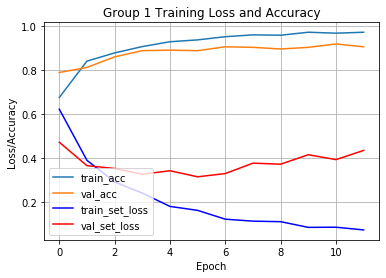

In [32]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
y_vacc = history.history['val_accuracy']
y_acc = history.history['accuracy']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_acc, label = "train_acc")
plt.plot(x_len, y_vacc, label = "val_acc")
plt.plot(x_len, y_loss, c='blue', label='train_set_loss')
plt.plot(x_len, y_vloss, c='red', label='val_set_loss')

plt.title("Group 1 Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc='lower left')
plt.grid()
plt.show()

In [33]:
from numpy import argmax

In [34]:
#X_guro, Y_guro   

yhat = model.predict_classes(X_guro)
yhat2 = model.predict(X_guro)

cnt = 0
for i in range(len(X_guro)):
    if int(argmax(y_guro[i]) == 1): cnt +=1 
    print('True: ' + str(argmax(y_guro[i])) + ', Predict: ', end='')
    for result in yhat2[i]:
        print(format(result, ".6f"), end=' ')
    print()

True: 1, Predict: 0.020392 0.979608 
True: 1, Predict: 0.001812 0.998188 
True: 0, Predict: 0.916572 0.083428 
True: 1, Predict: 0.000529 0.999471 
True: 0, Predict: 0.900030 0.099970 
True: 0, Predict: 0.992049 0.007951 
True: 0, Predict: 0.928932 0.071068 
True: 1, Predict: 0.000000 1.000000 
True: 1, Predict: 0.020471 0.979529 
True: 0, Predict: 0.828065 0.171935 
True: 0, Predict: 0.990220 0.009780 
True: 0, Predict: 0.045996 0.954004 
True: 0, Predict: 0.591384 0.408616 
True: 1, Predict: 0.002846 0.997154 
True: 1, Predict: 0.004779 0.995221 
True: 1, Predict: 0.570710 0.429290 
True: 0, Predict: 0.014028 0.985972 
True: 0, Predict: 0.053161 0.946839 
True: 1, Predict: 0.001112 0.998888 
True: 1, Predict: 0.003725 0.996275 
True: 1, Predict: 0.487560 0.512440 
True: 0, Predict: 0.009138 0.990862 
True: 0, Predict: 0.110340 0.889660 
True: 1, Predict: 0.987990 0.012010 
True: 1, Predict: 0.987990 0.012010 
True: 0, Predict: 0.995475 0.004525 
True: 0, Predict: 0.014028 0.985972 
T

In [35]:
print(len(X_guro))
print(cnt)

print(cnt / len(X_guro))

270
104
0.3851851851851852


In [36]:
# What do I have?
# guro_dataset,y_guro, yhat2
# How can I link them?

# combine guro_dataset, yhat
for i, guro in enumerate(guro_dataset):
    guro[2] = yhat2[i][1]
    
guro_dataset

[[1,
  [[37.633114, 127.05883500000002],
   [37.633114, 127.05883500000002],
   [37.495403100000004, 126.88736899999999],
   [37.633114, 127.05883500000002],
   [37.633114, 127.05883500000002],
   [37.633114, 127.05883500000002],
   [37.633114, 127.05883500000002],
   [37.495403100000004, 126.88736899999999],
   [37.633114, 127.05883500000002],
   [37.633114, 127.05883500000002]],
  0.97960836],
 [1,
  [[37.633114, 127.05883500000002],
   [37.633114, 127.05883500000002],
   [37.495403100000004, 126.88736899999999],
   [37.633114, 127.05883500000002],
   [37.633114, 127.05883500000002],
   [37.602695700000005, 126.9291119],
   [37.60245220000001, 126.92884740000001]],
  0.9981877],
 [0,
  [[37.602695700000005, 126.9291119],
   [37.60245220000001, 126.92884740000001],
   [37.60245220000001, 126.92884740000001],
   [37.6042789, 126.90508670000001]],
  0.08342768],
 [1,
  [[37.591014, 126.913582],
   [37.591014, 126.913582],
   [37.5910797, 126.91327240000001],
   [37.549575299999994, 126.

In [40]:
coordinates = []
probs = []
for i, guro in enumerate(guro_dataset):
    # for coordinates
    for coord in guro[1]:
        if len(coordinates) == 0:
            coordinates.append(coord)
            probs.append([guro[2]])
            continue
        if coord in coordinates:
            index = coordinates.index(coord)
            probs[index].append(guro[2])
        else:
            coordinates.append(coord)
            probs.append([guro[2]])

print(len(coordinates), len(probs))           
            

152 152


In [56]:
severe = 0
severe_coord = []
severe_prob = []
for i, coord in enumerate(coordinates):
    prob_sum = sum(p for p in probs[i])
    prob_real = prob_sum / len(probs[i])
    if prob_real > 0.8:
        severe += 1
        severe_coord.append(coord)
        severe_prob.append(prob_real)

In [57]:
img = np.zeros((256,256))

for i, coord in enumerate(severe_coord):
    if converter.isSeoul(coord[0], coord[1]):
        x, y = converter.toGrid(coord[0], coord[1])
        prob = severe_prob[i] * 255
        img[x, y] = prob

img = gray_image(img)
img.show()